In [7]:

import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import chardet
import datetime
%matplotlib inline
testing_pred = []
testing_actual = []

#Seed
random.seed(721521789)

# Read data from the CSV into a dataframe

#get Elo data and match data
#iterate over OS path contents, and load into a dictionary/list object all elos from all leagues
raw_elo = {}
raw_matches = {}
def set_match_week_window():
    return 11 #16 # window of 5, to calculate the 6th probabilities
    #return 11 # index_nth one is to be calculated, index_0 to index_n-1 is the window
f_HDA = {'H':0,'D':0,'A':0}
f_HDA_year_range = {'YYYY_start':-1, 'YYYY_end':-1}
f_HDA_metadata = {'Countries':[], 'Level':[]}
# default_day_HFA = "-07-22" ## 22 July YYYY is taken as the initial ELO HFA date

# #HFA updates country wide and daily - hence matches and elo updates need to be done for all teams
HFA_dict = {}

def fix_date_column(df):
    '''making the date column a time series column for easy traversal by date
    however we have 2 different date formats in our datasets

    # possible formats:
    #'%d/%m/%y'
    #'%d/%m/%Y'

    '''
    # sample_date = list(df.Date.values)
    sample_date = list(df.Date.values)
    # sample_date = (sample_date[:1])
    sample_date = sample_date[0]

    split_date = sample_date.split('/')
    if 0 <= int(split_date[2]) <= 99:
        df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%y')  # note small 'y'
    else:
        df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%Y')  # note capital 'Y'
    return df

# Define the function to compute the power rank
def get_power_rank(points_obtained, max_points):
    points_ratio = points_obtained/max_points
    # print(points_obtained, max_points,points_ratio)
    if points_ratio >= 0.7368:
        rank = 0
    elif points_ratio >= 0.7108:
        rank = 0
        # rank = 1
    elif points_ratio >= 0.6579:
        rank = 1
        # rank = 2
    elif points_ratio >= 0.6140:
        rank = 1
        # rank = 3
    elif points_ratio >= 0.5702:
        rank = 2
        # rank = 4
    elif points_ratio >= 0.5263:
        rank = 2
        # rank = 5
    elif points_ratio >= 0.4825:
        rank = 3
        # rank = 6
    elif points_ratio >= 0.4386:
        rank = 3
        # rank = 7
    elif points_ratio >= 0.3947:
        # rank = 8
        rank = 4
    elif points_ratio >= 0.3509:
        rank = 4
        # rank = 9
    elif points_ratio >= 0.3070:
        rank = 5
        # rank = 10
    elif points_ratio >= 0.2632:
        rank = 5
        # rank = 11
    elif points_ratio >= 0.2193:
        rank = 6
        # rank = 12
    else:
        rank = 6
        # rank = 13
    return rank


def get_points_from_window(df, team_name):
    # if len(df) == 0:
    #     return 0 # team promoted from previous season
    # else:

    # df= df_passed[(df_passed['HomeTeam'] == df_passed) | (df_passed['AwayTeam'] == df_passed)]

    home_matches_won = len(df[(df['HomeTeam'] == team_name) & (df['FTR'] == 'H')])
    away_matches_won = len(df[(df['AwayTeam'] == team_name) & (df['FTR'] == 'A')])
    drawn_matches_home = len(df[(df['HomeTeam'] == team_name) & (df['FTR'] == 'D')])
    drawn_matches_away = len(df[(df['AwayTeam'] == team_name) & (df['FTR'] == 'D')])

    return ((home_matches_won+away_matches_won)*3)+drawn_matches_home+drawn_matches_away


def sliding_window_power_ranks_and_frequencies_for_match(count_frequencies, df_prev, df_now, df_index, f_win, f_draw, f_loss, window_match_weeks, matches_per_week):
    '''Appends probabilities a home team wins, draws and loses, and the power ranks for a particular index'''
    # print(df_index)
    # print(count_frequencies)
    matches_wanted = window_match_weeks*matches_per_week # or 9 if bundesliga
    # print("input: ", len(df_prev[-matches_wanted:]))
    # print("original dfnow",len(df_now))
    original_df_index = df_index
    if df_index < matches_wanted:

        df_now = pd.concat([df_prev[-matches_wanted:],df_now], ignore_index=True)
        # print("df now after concat",len(df_now))
        df_index = df_index + ((window_match_weeks)*matches_per_week) # was -1

        # print(df_prev[-matches_wanted:])

    if df_now.iloc[df_index]['p_W'] == -1: # implies others ['p_W,p_D,p_A,HomePower, AwayPower'] are -1 as well
        # print(df_now)

        match_row = df_now.iloc[df_index]
        home_team = match_row['HomeTeam']
        away_team = match_row['AwayTeam']
        # print(df_index, df_index-((window_match_weeks-1)*matches_per_week))
        win_size = window_match_weeks-1
        current_match_week = int(df_index / matches_per_week)
        # print(df_index, current_match_week, "current index ->matchweek")
        tmp_start =(matches_per_week * current_match_week)-(win_size *matches_per_week)


        tmp_end = (matches_per_week * current_match_week)
        # print("start and end indices ", tmp_start, tmp_end)
        # tmp_df = df_now.iloc[0:df_index]
        tmp_df = df_now.iloc[tmp_start:tmp_end]
        # print(len(tmp_df), "len of selection")
        # print(tmp_df)

        home_last_x_matches = tmp_df[(tmp_df['HomeTeam'] == home_team) | (tmp_df['AwayTeam'] == home_team)].tail(win_size)
        #.iloc[df_index-(window_match_weeks-1):df_index]
        away_last_x_matches = tmp_df[(tmp_df['HomeTeam'] == away_team) | (tmp_df['AwayTeam'] == away_team)].tail(win_size)
        # away_last_x_matches = df_now[(df_now['HomeTeam'] == away_team) | (df_now['AwayTeam'] == away_team)].iloc[df_index-((window_match_weeks-1)*matches_per_week):df_index]

        # print("last matches h:a ", len(home_last_x_matches), len(away_last_x_matches))
        home_points = get_points_from_window(home_last_x_matches, home_team)
        away_points = get_points_from_window(away_last_x_matches, away_team)
        # print(f"home points {home_points} \t away points {away_points}")
        # get power rank
        home_power = get_power_rank(home_points, (window_match_weeks-1)*3)
        away_power = get_power_rank(away_points, (window_match_weeks-1)*3)



        # add data to dataframe
        if not count_frequencies:
            # print(df_index)
            # elicit probabilities
            # print(f_win[home_power,away_power],f_draw[home_power,away_power],f_loss[home_power,away_power])
            total = float(f_win[home_power,away_power]+f_draw[home_power,away_power]+f_loss[home_power,away_power])
            # print(total)
            if total == 0:
                # assign summed probabilities because match was never played
                total = np.sum((frequencies_home_win+frequencies_home_loss+frequencies_home_draw))
                p_w = np.sum(frequencies_home_win)/total
                p_d = np.sum(frequencies_home_loss)/total
                p_l = np.sum(frequencies_home_draw)/total
            else:
                p_w = f_win[home_power,away_power]/total
                p_d = f_draw[home_power,away_power]/total
                p_l = f_loss[home_power,away_power]/total
            df_now.loc[df_index,'p_W'] = p_w
            df_now.loc[df_index,'p_D'] = p_d
            df_now.loc[df_index,'p_A'] = p_l
            # print(df_now.loc[df_index,'p_W'],df_now.loc[df_index,'p_D'],df_now.loc[df_index,'p_A'],)
            # print(df_now.iloc[df_index])
        else:
            match_result = match_row['FTR']
            if match_result == 'H':
                frequencies_home_win[home_power,away_power] += 1
            elif match_result == 'A':
                frequencies_home_loss[home_power,away_power] += 1
            else:
                frequencies_home_draw[home_power,away_power] += 1

        df_now.loc[df_index,'HomePower'] = home_power
        df_now.loc[df_index,'AwayPower'] = away_power
        # print(len(df_now), "END DFNOW")

    if original_df_index < matches_wanted:
        # print(df_now)
        # print(f"returned smaller {original_df_index}",len(df_now[matches_wanted:len(df_now)].reset_index(drop=True)))
        return df_now[matches_wanted:len(df_now)].reset_index(drop=True)
    else:
        # print(f"returned greater {original_df_index}",len(df_now))
        return df_now




#Gets all the statistics related to gameplay and elo
# bookmakers available columns
# bookmakers = ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'PS', 'SO', 'SB', 'SJ', 'SY', 'VC', 'WH', 'BbAv']
# game_outcomes = ['H', 'D', 'A']
odds_wanted = ['B365H','B365D','B365A']

match_columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']
elo_columns_req = ['Club', 'Elo']

for country in ['ENG','ESP','GER','ITA']:
    for level in [1,2]:
        for year in range(1994,2023):
            key = f"{country}\{level}\{year}" # keys are as in the following format: ENG\1\2000 etc
            path_elo = f".\\clubelo\{key}-08-01.csv"
            path_matches_trimmed = f".\\football_data_trimmed\{key}.csv"
            path_matches_untrimmed = f".\\football_data_untrimmed\{key}.csv"

            raw_elo[key] = pd.read_csv(path_elo)
            try:
                with open(path_matches_untrimmed, 'rb') as f:
                    result = chardet.detect(f.read())

                encoding = (result['encoding'])
                print(key)
                if year >= 2011:

                    cols_needed = match_columns_req+odds_wanted
                    raw_matches[key] = pd.read_csv(path_matches_untrimmed, usecols=cols_needed, encoding=encoding)
                    raw_matches[key].dropna(subset=cols_needed, inplace=True) #filtered by subset otherwise all rows with a null are removed
                else:
                    raw_matches[key] = pd.read_csv(path_matches_trimmed, delimiter=',', quoting=csv.QUOTE_ALL )
                    # raw_matches[key] = raw_matches[key].dropna()
                    raw_matches[key].dropna(subset=match_columns_req, inplace=True) #filtered by subset otherwise all rows with a null are removed
                    # print(raw_matches[key])
                raw_matches[key] = fix_date_column(raw_matches[key])
                raw_matches[key].sort_values(by='Date', inplace=True)

                new_columns = {
                    'p_W':-1.0,
                    'p_D':-1.0,
                    'p_A':-1.0,
                    'HomePower':-1,
                    'AwayPower':-1,
                }
                raw_matches[key] = raw_matches[key].assign(**new_columns)
                # print(raw_matches[key])
            except FileNotFoundError:
                print(f"skipping due to lack of data {key}")

    #load HFA data
    # if country not in HFA_dict.keys():
    #     #load HFA
    #     path_HFA = f".\\HFA\\{country}.csv"
    #     #dict in following format {"{COUNTRY}\\{YEAR}"(numeric key): [DATE, HFA_value]}
    #     HFA_df = pd.read_csv(path_HFA)
    #     HFA_df["HFA_KEY"] = HFA_df["COUNTRY"]+HFA_df["YEAR"].astype(str)
    #     HFA_df["DATE"] = pd.to_datetime(HFA_df['DATE'], format='%Y-%m-%d')
    #     for idx, row in HFA_df.iterrows():
    #         HFA_dict[row.HFA_KEY] = [row.HFA, row.DATE]

# elo_data_dict = raw_elo
match_data_dict = raw_matches
# matches probabilities
frequencies_home_win = np.zeros((7,7)).astype(int)
frequencies_home_loss = np.zeros((7,7)).astype(int)
frequencies_home_draw = np.zeros((7,7)).astype(int)
# frequencies_home_win = np.zeros((14,14)).astype(int)
# frequencies_home_loss = np.zeros((14,14)).astype(int)
# frequencies_home_draw = np.zeros((14,14)).astype(int)
# frequencies_MCS_posterior = np.zeros((380,3)).astype(int)


def get_actual_outcome(home_score, away_score):
    '''
    Get the actual result
    returns [1,0] if home team win
    returns [0,1] if home team lost
    returns [0.5, 0.5] if home team draws
    '''
    if home_score<away_score:
        return [0,1]
    elif home_score>away_score:
        return [1,0]
    elif home_score==away_score:
        return [0.5, 0.5]


import math
def round(elo_rank):
    #code from https://stackoverflow.com/questions/8866046/python-round-up-integer-to-next-hundred
    return int(math.ceil(elo_rank / 100.0)) * 100

# def get_rank(elo):
#     if elo >= 2100: return 6
#     elif elo < 1500: return 0
#     else:
#         return int((elo-1500)/100)
# def get_rank(elo):
#     if elo >= 2100: return 13
#     elif elo < 800: return 0
#     else:
#         return int((elo-800)/100)

# def get_idx(elo_home, elo_away):
#     return [get_rank(elo_home), get_rank(elo_away)]



ENG\1\1994
ENG\1\1995
ENG\1\1996
ENG\1\1997
ENG\1\1998
ENG\1\1999
ENG\1\2000
ENG\1\2001
ENG\1\2002
ENG\1\2003
ENG\1\2004
ENG\1\2005
ENG\1\2006
ENG\1\2007
ENG\1\2008
ENG\1\2009
ENG\1\2010
ENG\1\2011
ENG\1\2012
ENG\1\2013
ENG\1\2014
ENG\1\2015
ENG\1\2016
ENG\1\2017
ENG\1\2018
ENG\1\2019
ENG\1\2020
ENG\1\2021
ENG\1\2022
ENG\2\1994
ENG\2\1995
ENG\2\1996
ENG\2\1997
ENG\2\1998
ENG\2\1999
ENG\2\2000
ENG\2\2001
ENG\2\2002
ENG\2\2003
ENG\2\2004
ENG\2\2005
ENG\2\2006
ENG\2\2007
ENG\2\2008
ENG\2\2009
ENG\2\2010
ENG\2\2011
ENG\2\2012
ENG\2\2013
ENG\2\2014
ENG\2\2015
ENG\2\2016
ENG\2\2017
ENG\2\2018
ENG\2\2019
ENG\2\2020
ENG\2\2021
ENG\2\2022
ESP\1\1994
ESP\1\1995
ESP\1\1996
ESP\1\1997
ESP\1\1998
ESP\1\1999
ESP\1\2000
ESP\1\2001
ESP\1\2002
ESP\1\2003
ESP\1\2004
ESP\1\2005
ESP\1\2006
ESP\1\2007
ESP\1\2008
ESP\1\2009
ESP\1\2010
ESP\1\2011
ESP\1\2012
ESP\1\2013
ESP\1\2014
ESP\1\2015
ESP\1\2016
ESP\1\2017
ESP\1\2018
ESP\1\2019
ESP\1\2020
ESP\1\2021
ESP\1\2022
skipping due to lack of data ESP\2\1994
ski

In [8]:

def get_rps_HDA(f_prob, o_true):
    """Adapted from https://opisthokonta.net/?p=1333"""
    r = f_prob.shape[1]
    n = f_prob.shape[0] # total matches
    rps = np.zeros(n) #initialise array with 0s

    for j in range(n):
        cumulative = 0
        for i in range(0,r):
            cumulative += (np.sum(f_prob[j, 0:i+1]) - np.sum(o_true[j, 0:i+1])) ** 2
        rps[j] = (1/(r-1))*cumulative
    # print(rps)
    return rps


def get_brier_score_and_rps(o_true, f_prob):
    """
    Calculate the multi-class Brier score for home win/draw/loss for the matches played.

    Parameters:
    y_true one-hot encoded 2D array
    y_prob predicted probabilities for each class stored in a 2D array

    Returns:
    brier_score (float): the multi-class Brier score
    """

    # Convert to numpy arrays
    o_true = np.array(o_true)
    f_prob = np.array(f_prob)

    # Calculate the squared difference between the predicted probabilities and the true classes
    squared_diff = np.sum((f_prob - o_true) ** 2, axis=1)

    # Calculate the mean squared difference, i.e. the Brier Score
    brier_score = np.mean(squared_diff)

    # Calculate RPS

    # Sum up the squared differences for each rank and divide by n
    rps = get_rps_HDA(f_prob, o_true)

    # rps_avg = (1/len(rps))*np.sum(np.array(rps))
    rps_avg = np.mean(np.array(rps))

    # rps_avg = rps['H']+rps['D']+rps['A']/3
    # Return the Brier score & RPS values
    return brier_score, rps, rps_avg

def get_one_hot_encoded(outcome):
    """
    Converts HDA to a one hot encoded outcome.

    :param outcome: either 'H', 'D', or 'A'
    :return:
        3 bit number, as a list object
    """
    if outcome == 'H':
        return [1, 0, 0]
    elif outcome == 'A':
        return [0, 0, 1]
    else:
        #outcome == 'D'
        return [0, 1, 0]


In [9]:

# def calculate_elo(elo_home, elo_away, HFA, home_score, away_score, count_frequencies=False, simulation=False):
#     k = k_value()
#     # actual_outcome = get_actual_outcome(home_score,away_score)
#     # home_win, away_win = actual_outcome[0],actual_outcome[1]
#     # print(f"{elo_home} vs {elo_away} calculating elo")
#     home_win, away_win = get_actual_outcome(home_score,away_score)
#     p_home_win, p_away_win = get_expected_outcome(elo_home, elo_away, HFA)
#     # print(f"{p_home_win} {p_away_win}")
#     idx_home, idx_away = get_idx(elo_home,elo_away)
#     if home_win == 0.5:
#         #old elo point exchange (no weighting goal diff as margin is 0)
#         new_elo_home = elo_home + k*(home_win-p_home_win)
#         new_elo_away = elo_away + k*(away_win-p_away_win)
#     else:
#         margin = abs(home_score-away_score)
#         deltaElo = k*(home_win-p_home_win)
#         deltaElo_1goal = deltaElo/(get_weighted_sum_over_margin( home_score, away_score))
#         #new elo point exchange must be considered (weighted goal diff)
#         new_elo_home = elo_home + (deltaElo_1goal*math.sqrt(margin))
#         new_elo_away = elo_away - (deltaElo_1goal*math.sqrt(margin))
#         # new_elo_away = elo_away + k*(away_win-p_away_win)
#     #
#     # if not simulated:
#     if count_frequencies and not simulation:
#         # log frequencies to get probabilities according to the difference
#         # if count_frequencies:
#         ratio = elo_home/elo_away
#         idx = bucket_ratio(round_2dp(ratio))
#         if home_win == 0:
#             frequencies_home_loss[idx]+=1
#         elif home_win == 1:
#             frequencies_home_win[idx]+=1
#         elif home_win == 0.5:
#             frequencies_home_draw[idx]+=1
#
#     return new_elo_home, new_elo_away


def update_points(current_points, simulated_outcome, home_team, away_team):
    # Set initial points to home/away team to 0 if not set
    if home_team not in current_points.keys():
        current_points[home_team] = 0
    if away_team not in current_points.keys():
        current_points[away_team] = 0

    #calculating and updating points
    if simulated_outcome == 'H':
        current_points[home_team] += 3
    elif simulated_outcome == 'A':
        current_points[away_team] += 3
    else:
        # game drawn
        current_points[home_team] += 1
        current_points[away_team] += 1
    # print(current_points)
    return current_points

def round_2dp(ratio):
    return math.ceil(ratio*100)/100

# def bucket_ratio(rounded_ratio):
#
#     if rounded_ratio < 0.7:
#         return 0
#     elif rounded_ratio >= 1.35:
#         return 65 # 65?
#     else:
#         #y= 0.01x+0.7
#         return int((rounded_ratio-.7)/0.01)

In [10]:


def simulate_outcome_on_power_rank_frequencies(idx_home, idx_away, o_true, f_prob):
    total = frequencies_home_win[idx_home][idx_away]+frequencies_home_loss[idx_home][idx_away]+frequencies_home_draw[idx_home][idx_away]

    if total != 0:
        # use league rank vs rank probabilities
        print("total 1")
        p_H = frequencies_home_win[idx_home][idx_away]/total
        p_A = frequencies_home_loss[idx_home][idx_away]/total
        p_D = frequencies_home_draw[idx_home][idx_away]/total
        #consider sliding window for sampling frequencies(most recent x results)
    else:
        # get league HAD probabilities
        print("total 0")
        total = np.sum(frequencies_home_win)+np.sum(frequencies_home_loss)+np.sum(frequencies_home_draw)
        p_H = np.sum(frequencies_home_win)/total
        p_A = np.sum(frequencies_home_loss)/total
        p_D = np.sum(frequencies_home_draw)/total

    # get forecasted outcome
    forecasted_outcome = random.choices(['H','A','D'], weights=(p_H*100,p_A*100,p_D*100), k=1)[0]

    # append to list
    f_prob.append([p_H, p_D, p_A])
    o_true.append(get_one_hot_encoded(forecasted_outcome))


    # print((p_H*100,p_A*100,p_D*100))
    # print(random.choices(['H','A','D'], weights=(p_H*100,p_A*100,p_D*100), k=1))
    return forecasted_outcome, o_true, f_prob

def plot_rps(x_axis, y_axis, title, x_label, y_label):
    # plt.
    plt.plot(x_axis, y_axis, color ='maroon')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=np.mean(np.array(y_axis)), color ='blue')
    plt.show()

# def get_simulated_balances(simulated_outcome):
#     # print(frequencies_MCS_posterior)
#     # prob_MCS_matches = frequencies_MCS_posterior / np.sum(frequencies_MCS_posterior, axis=1, keepdims=True) # axis = 1 sums each row separately, keep dims = keeps same dimensions, otherwise we get a sum per row
#
#     # max_indices = np.argmax(p_hda, axis=1) # get indices of maximum values
#     # bets_outcome = (np.eye(prob_MCS_matches.shape[1])[max_indices]).astype(int) # one hot encode marked indices - we will take the highest occurring outcome and bet upon it
#
#     BET_EURO = 10 # everytime we bet 10 euro
#     balance = 3800 # we have 1000 euro in our bank
#
#     potential_payout = np.array(simulated_outcome) * bet365_odds * BET_EURO
#     pay_out = potential_payout * observed
#     balance_forecasted_season = []
#     for pay in pay_out:
#         balance -= 10
#         balance += np.sum(pay)
#         balance_forecasted_season.append(balance)
#     return balance_forecasted_season
    # plot_multiplelines(range(0,len(balance_historical),1), balance_historical, "Balance of the simple betting model", "Game number", "Balance")
def get_simulated_balances(strategy_name,forecasted, actual_outcomes):

    max_indices = np.argmax(forecasted, axis=1) # get indices of maximum values
    # print(max_indices)
    BUDGET_MATCH_EURO = 10 # everytime we bet 10 euro

    balance = len(forecasted) * BUDGET_MATCH_EURO
    balance_forecasted_season = []

    bet365 = np.array(bet365_odds)

    f_p = np.array(forecasted)
    bet_euro = BUDGET_MATCH_EURO
    forecasted_outcome = (np.eye(f_p.shape[1])[max_indices]).astype(int) #
    observed_outcome = np.array(actual_outcomes)
    # print(forecasted_outcome)


    if strategy_name == 'Simple':
        potential_payout = forecasted_outcome * bet_euro * bet365
        pay_out = potential_payout * observed_outcome

        for pay in pay_out:
            # print(pay)
            # print(bet_euro)
            balance -= bet_euro
            balance += np.sum(pay)
            balance_forecasted_season.append(balance)
    else:
        #strategy name =='Kelly'
        potential_payout = np.zeros((len(forecasted_outcome),3)).astype(float)
        pay_out = np.zeros((len(forecasted_outcome),3)).astype(float)
        idx_match = 0
        for match_res in max_indices:
            # get max probability
            bet_euro = BUDGET_MATCH_EURO
            idx_outcome = match_res
            odds = bet365[idx_match][idx_outcome]
            p_odd_true = f_p[idx_match][idx_outcome]
            # print(f"odds:{bet365[idx_matc;]*]}")
            # print(f"freq:{f_p[idx_match]}")
            stake = ((odds * p_odd_true) - (1-p_odd_true))/odds ##
            # print(f"stake:{stake}")
            bet_euro = bet_euro * stake
            # print(f"bet_euro:{bet_euro * stake}")
            potential_payout[idx_match,idx_outcome] = bet_euro * odds
            pay_out[idx_match,idx_outcome] = potential_payout[idx_match,idx_outcome]
            balance -= bet_euro # within match context
            balance += pay_out[idx_match,idx_outcome] # potential_payout[idx_match,idx_outcome]
            balance_forecasted_season.append(balance)
            idx_match += 1

    return balance_forecasted_season
    # plot_multiplelines(range(0,len(balance_historical),1), balance_historical, "Balance of the simple betting model", "Game number", "Balance")

bet365_odds = []
observed = []


def plot_balances_simulated(x_axis, y_axis, title, x_label, y_label):
    # plt.
    for y_list in y_axis:
        color = ""
        last_bal = y_list[-1]
        if last_bal < 3800:
            color += "red"
        elif last_bal > 3800:
            color += "green"
        else:
            # sum_y == 1000
            color += "blue"
        plt.plot(x_axis, y_list, color=color)
        colour = ''
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=np.mean(np.array(y_axis)), color ='black')
    plt.show()



def plot_graph(x_axis, y_axis, title, x_label, y_label):
    # plt.
    plt.bar(x_axis, y_axis, color ='maroon',
            width = 0.01)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [11]:
def update_points(current_points, simulated_outcome, home_team, away_team):
    # Set initial points to home/away team to 0 if not set
    if home_team not in current_points.keys():
        current_points[home_team] = 0
    if away_team not in current_points.keys():
        current_points[away_team] = 0

    #calculating and updating points
    if simulated_outcome == 'H':
        current_points[home_team] += 3
    elif simulated_outcome == 'A':
        current_points[away_team] += 3
    else:
        # game drawn
        current_points[home_team] += 1
        current_points[away_team] += 1
    # print(current_points)
    return current_points

ENG 2014-2015 1
380
ENG 2015-2016 1
760
ENG 2016-2017 1
1140
Iteration: 1/10
Iteration: 2/10
Iteration: 3/10
Iteration: 4/10
Iteration: 5/10
Iteration: 6/10
Iteration: 7/10
Iteration: 8/10
Iteration: 9/10
Iteration: 10/10
Brier Score 0.5834274785808663 for ENG1 : 2017-2018 season
RPS_avg 0.2079263968228409 for ENG1 : 2017-2018 season


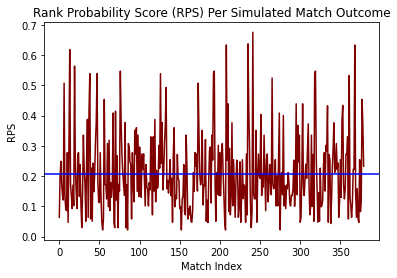

              Team  Simulated Average Points
1         Man City                      59.5
2        Tottenham                      55.6
3       Man United                      52.5
4        Liverpool                      51.1
5          Swansea                      51.0
6          Chelsea                      51.0
7          Arsenal                      50.2
8          Everton                      50.1
9      Bournemouth                      49.9
10  Crystal Palace                      47.1
11        West Ham                      45.9
12    Huddersfield                      45.8
13       Leicester                      43.8
14         Watford                      43.5
15       Newcastle                      42.5
16           Stoke                      42.4
17       West Brom                      41.9
18     Southampton                      40.7
19        Brighton                      40.5
20         Burnley                      37.7


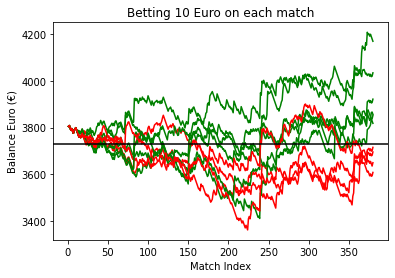

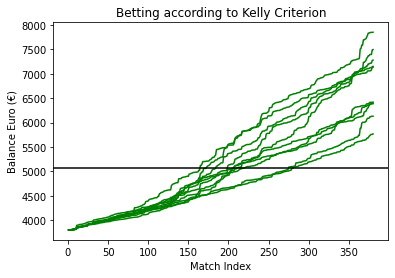

C:\Users\steve\AppData\Local\Temp/ipykernel_8528/1944134829.py:137: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_HDA_metadata_array = np.array([f_HDA_metadata[k] for k in f_HDA_metadata])


In [12]:


def play_k_matches(simulation, Country='ENG', Level='1', k=20000, YYYY_start = 2021, YYYY_end=2022):
    match_week_window = set_match_week_window()
    simulated_points={}
    all_points = {}
    simulated_simple_balance=[]
    simulated_kelly_balance=[]
    o_true, f_prob = [], []

    if (Country == 'ENG' or Country == 'ESP' or Country == 'ITA') and Level == '1':
        matches_per_week = 10
    elif Country == 'GER':
        matches_per_week = 9
    elif Country=='ENG' and Level == '2':
        matches_per_week = 12
    else:
        #ITA and ESP level 2
        matches_per_week = 11

    for z in range(0,k):
        outcomes_simulated = []
        print(f"Iteration: {z+1}/{k}")
        for YYYY in range(YYYY_start, YYYY_end):
            # Creating the empty dictionary that is going to store the current elo for each national team
            current_points={}
            o_true, f_prob = [],[]
            match_data_dict[f"{Country}\\{Level}\\{YYYY}"]['p_W'] = -1
            match_data_dict[f"{Country}\\{Level}\\{YYYY}"]['p_D'] = -1
            match_data_dict[f"{Country}\\{Level}\\{YYYY}"]['p_A'] = -1
            match_data_dict[f"{Country}\\{Level}\\{YYYY}"]['HomePower'] = -1
            match_data_dict[f"{Country}\\{Level}\\{YYYY}"]['AwayPower'] = -1


            df = match_data_dict[f"{Country}\\{Level}\\{YYYY}"].reset_index()
            df_prev = match_data_dict[f"{Country}\\{Level}\\{YYYY-1}"].reset_index()
            # df.head(10)
            for idx,row in df.iterrows():

                # match_date = df.iloc[idx]['Date']
                home_team=df.iloc[idx]["HomeTeam"]
                away_team=df.iloc[idx]["AwayTeam"]
                # home_score=df.iloc[idx]['FTHG']
                # away_score=df.iloc[idx]['FTAG']
                actual_outcome = df.iloc[idx]['FTR']


                df = sliding_window_power_ranks_and_frequencies_for_match(False, df_prev, df, idx, frequencies_home_win, frequencies_home_draw, frequencies_home_loss, match_week_window, matches_per_week) # ex 7 matchweeks as a window
                match_row_df = df.iloc[idx]
                idx_home = match_row_df['HomePower']
                idx_away = match_row_df['AwayPower']
                p_w = match_row_df['p_W']
                p_d = match_row_df['p_D']
                p_l = match_row_df['p_A']
                # print(match_row_df)
                # print(p_w,p_l,p_d)
                # total = p_w+p_d+p_l
                # if total == 1:
                #     # use league rank vs rank probabilities
                #     print("total 1")
                #     p_H = p_w
                #     p_D = p_d
                #     p_A = p_l
                # else:
                #     # get league HAD probabilities
                #
                #     print("total 0")
                #     total = np.sum(frequencies_home_win)+np.sum(frequencies_home_loss)+np.sum(frequencies_home_draw)
                #     p_H = np.sum(frequencies_home_win)/total
                #     p_A = np.sum(frequencies_home_loss)/total
                #     p_D = np.sum(frequencies_home_draw)/total

                # get forecasted outcome
                forecasted_outcome = random.choices(['H','A','D'], weights=(p_w*100,p_l*100,p_d*100), k=1)[0]

                # append forecasted outcome instead of FTR at the moment
                df.loc[idx, 'FTR'] =forecasted_outcome
                match_data_dict[f"{Country}\\{Level}\\{YYYY}"].loc[idx, 'FTR'] = forecasted_outcome



                f_prob.append([p_w, p_d, p_l])
                # print(f_prob)
                o_true.append(get_one_hot_encoded(forecasted_outcome))

                current_points = update_points(current_points, forecasted_outcome, home_team, away_team)
                #append observed
                outcomes_simulated.append(o_true[-1])
                if z == 0:
                    bet365_odds.append([row['B365H'],row['B365D'],row['B365A']])

                    observed.append(get_one_hot_encoded(actual_outcome))
            #match statistics saving
            #save sum of all points obtained by each team over k iterations
            for team in current_points.keys():
                if team not in simulated_points.keys():
                    # simulated_points[team] = []
                    simulated_points[team] = 0
                    all_points[team] = []
                else:
                    # simulated_points[team].append(tmp_points[team])
                    simulated_points[team] += current_points[team]
                    all_points[team].append(current_points[team])
                    if z == k-1:
                        #avg points
                        simulated_points[team] /= k
            # print(current_points)
        simulated_simple_balance.append(get_simulated_balances("Simple",f_prob, observed))
        simulated_kelly_balance.append(get_simulated_balances("Kelly",f_prob, observed))


    brier_score, rps_all, rps_avg = get_brier_score_and_rps(o_true, f_prob)
    print(f"Brier Score {brier_score} for {Country}1 : {YYYY_start-1}-{YYYY_end-1} season")
    print(f"RPS_avg {rps_avg} for {Country}1 : {YYYY_start-1}-{YYYY_end-1} season")
    plot_rps(range(0,len(rps_all),1),rps_all,"Rank Probability Score (RPS) Per Simulated Match Outcome", "Match Index", "RPS")

    #now attempt to save in a dataframe and order by the points gained
    points_df = pd.DataFrame(simulated_points.items(), columns=["Team","Simulated Average Points"])
    points_df = points_df.sort_values(by=["Simulated Average Points"], ascending=False, ignore_index=True)
    points_df.index += 1
    print(points_df)

    #now see potential profit
    plot_balances_simulated(range(1,len(simulated_simple_balance[0])+1,1),simulated_simple_balance, f"Betting 10 Euro on each match",  "Match Index", "Balance Euro (€)")
    plot_balances_simulated(range(1,len(simulated_kelly_balance[0])+1,1),simulated_kelly_balance, f"Betting according to Kelly Criterion",  "Match Index", "Balance Euro (€)")

    # Standardise data to numpy data

    team_names = points_df['Team'].to_numpy()
    expected_points = points_df['Simulated Average Points'].to_numpy()
    country_data = np.array([Country])
    level_data = np.array([Level])
    YYYY_range_file_names = np.array([YYYY_start,YYYY_end]) # start season and end season
    brier_score_and_rps_avg = np.array([brier_score, rps_avg])
    # other data: simulated_balance_history,, o_true, f_prob, frequencies_home_win, frequencies_home_draw, frequencies_home_loss

    f_HDA_array = np.array([f_HDA[k] for k in f_HDA])
    f_HDA_year_range_array = np.array([f_HDA_year_range[k] for k in f_HDA_year_range])
    f_HDA_metadata_array = np.array([f_HDA_metadata[k] for k in f_HDA_metadata])


# Save data
    np.savez(f"./evaluate/{match_week_window} Window Naive Power Ranks {k} MCS DIST_short {Country}{Level} {YYYY_start-1}_{YYYY_end-1} season.npz",
             team_names=team_names,
             expected_points=expected_points,
             all_points=all_points,
             simulated_simple_balance=simulated_simple_balance,
             simulated_kelly_balance=simulated_kelly_balance,
             brier_score_and_rps_avg=brier_score_and_rps_avg,
             rps_all=rps_all,
             o_true=o_true,
             f_prob=f_prob,
             country_data=country_data,
             level_data=level_data,
             YYYY_range_file_names=YYYY_range_file_names,
             frequencies_home_win=frequencies_home_win,
             frequencies_home_draw=frequencies_home_draw,
             frequencies_home_loss=frequencies_home_loss,
             score_log=[],
             f_HDA=f_HDA_array,
            f_HDA_year_range=f_HDA_year_range_array,
             f_HDA_metadata=f_HDA_metadata_array)



def play_matches(Countries=['ENG','GER','ESP','ITA'], Levels= [1,2], YYYY_start = 2021, YYYY_end=2022):
    match_week_window= set_match_week_window()
    f_HDA_metadata['Countries']=Countries
    f_HDA_metadata['Levels']=Levels
    f_HDA_year_range['YYYY_start']=YYYY_start
    f_HDA_year_range['YYYY_end']=YYYY_end
    for Country in Countries:
        for Level in Levels:

            if (Country == 'ENG' or Country == 'ESP' or Country == 'ITA') and Level == 1:
                matches_per_week = 10
            elif Country == 'GER':
                matches_per_week = 9
            elif Country=='ENG' and Level == 2:
                matches_per_week = 12
            else:
                #ITA and ESP level 2
                matches_per_week = 11
            for YYYY in range(YYYY_start, YYYY_end):
                print(Country, f"{YYYY-1}-{YYYY}", Level)
                # print(len(match_data_dict[f"{Country}\\1\\{YYYY}"]))
                # print(len(match_data_dict[f"{Country}\\2\\{YYYY}"]))

                df = match_data_dict[f"{Country}\\{Level}\\{YYYY}"]
                df_prev = match_data_dict[f"{Country}\\{Level}\\{YYYY-1}"]

                for id_play,row_play in df.iterrows():
                    df = sliding_window_power_ranks_and_frequencies_for_match(True, df_prev, df, id_play, frequencies_home_win, frequencies_home_draw, frequencies_home_loss, match_week_window, matches_per_week) # ex 7 matchweeks as a window

                match_data_dict[f"{Country}\\{Level}\\{YYYY}"] = df

                print(np.sum(frequencies_home_loss+frequencies_home_win+frequencies_home_draw))


import matplotlib.colors

# play_matches(Countries=['ENG'], Levels=[1], YYYY_start=1998, YYYY_end=2018)
play_matches(Countries=['ENG'], Levels=[1], YYYY_start=2015, YYYY_end=2018)
# print(frequencies_home_win)
# print(frequencies_home_draw)
# print(frequencies_home_loss)
play_k_matches(False, 'ENG', '1', 10, 2018, 2019) #2017-2018 only played